In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
import pandas as pd
import os
import random
import shutil 
from seaborn import heatmap

In [3]:
categories=("A", "B", "C", "D", "E", "F")
NUM_OUTPUTS= len(categories)
IMG_SIZE=(322, 322)
input_shape = IMG_SIZE + (3,)

In [4]:
def split_to_train_test(folder):
    
    train_dir = folder+"train"
    test_dir = folder+"test"
    os.mkdir(test_dir)
    os.mkdir(train_dir)
    for name in categories:
        photo_dir = folder+"Apple/Apple "+name
        
        photos = os.listdir(photo_dir)
        
        os.mkdir(os.path.join(train_dir, name))
        os.mkdir(os.path.join(test_dir, name))
        
        for idx, photo in enumerate(photos):

            if random.random() < 0.9:
                dest_dir = train_dir
            else:
                dest_dir = test_dir

            src_path = os.path.join(photo_dir, photo)
           
            dest_path = os.path.join(dest_dir, name, photo)
         
            shutil.copy(src_path, dest_path)


In [5]:
def load_random_photo(folder):
    files = os.listdir(folder)
    random_file = random.choice(files)
    
    img = cv2.imread(folder+"/"+random_file)
    img = transform_photo(img)
    class_img=random_file[0]
    return img, class_img

def transform_photo(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    new_img = cv2.resize(new_img, (322, 480))
    return new_img

def show_photo(img, category):
    print("Kategoria zdjęcia: " +category)
    fig = plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()
    

                     

In [6]:
def plot_history(history):
    fig, ax = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
    # wyświetlamy wykresy
    ax[0][0].plot(history.history["loss"])
    ax[0][1].plot(history.history["accuracy"])
    ax[1][0].plot(history.history["val_loss"])
    ax[1][1].plot(history.history["val_accuracy"])
    #nazywamy zdjęcia
    ax[0][0].set_title("train loss")
    ax[0][1].set_title("train accuracy")
    ax[1][0].set_title("validation loss")
    ax[1][1].set_title("validation accuracy")
    plt.show()

In [7]:
def create_generators(folder, batch_size= 56, n_val = 0.0):
    train_data_dir = os.path.join(folder, 'train')

    test_data_dir = os.path.join(folder, 'test')


    # tworzymy obiekt ImageDataGenerator dla danych treningowych
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split= 0.1)

    # tworzymy obiekt ImageDataGenerator dla danych testowych
    test_datagen = ImageDataGenerator(rescale=1./255)

    # generator danych treningowych
    train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(322, 322),
            batch_size=batch_size,
            class_mode='categorical',
            subset ="training", 
            shuffle=True
    )

    val_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(322, 322),
            batch_size=batch_size,
            class_mode='categorical',
            subset ="validation", 
            shuffle=False
    )

    # generator danych testowych
    test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(322, 322),
            batch_size=batch_size,
            class_mode='categorical', 
            shuffle=False
    )
    return train_generator, val_generator, test_generator


In [8]:
def create_model():
    shape_img = input_shape
    
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(322))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(NUM_OUTPUTS))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

def load_model(name):
    return tf.keras.models.load_model(name)

In [9]:
def load_netv2_model ():
    inputLayer = tf.keras.Input(shape=(input_shape))
    # bierzemy wytrenowany wcześniej model
    base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',  # wczytaj z nauczonymi wagami
    input_shape=input_shape,
    include_top=False)   # nie dołączaj ostatniej warstwy k\

    # nie chcemy aby nauczony już feature extractor się uczył
    base_model.trainable = False\

    # dodajemy ostatnie warstwy klasyfikatora
    x = base_model(inputLayer, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(6, activation="softmax")(x)

    # zamykamy w kerasowy model
    model_2 = tf.keras.Model(inputLayer, output)
    model_2.summary()

    # kompilujemy całość
    model_2.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model_2

PROGRAM

In [ ]:
#     split_to_train_test("data/")

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
BATCH_SIZE = 56
N_VALIDATION = 0.1


In [20]:
train_generator, val_generator, test_generator = create_generators("/content/drive/MyDrive/4 Deep Learning - Types of apples/data", batch_size= BATCH_SIZE, n_val = N_VALIDATION)

Found 5036 images belonging to 6 classes.
Found 556 images belonging to 6 classes.
Found 546 images belonging to 6 classes.


Function to split data to usefull folders

In [21]:
model = create_model()
#model.summary()
#model = load_netv2_model()

In [22]:
history = model.fit_generator(generator=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps= len(val_generator)
                             )

<ipython-input-22-3025f5aa6b5c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/10
90/90 [==============================] - 64s 626ms/step - loss: 0.7722 - accuracy: 0.6964 - val_loss: 0.3276 - val_accuracy: 0.8669
Epoch 2/10
90/90 [==============================] - 53s 589ms/step - loss: 0.0796 - accuracy: 0.9730 - val_loss: 0.1014 - val_accuracy: 0.9586
Epoch 3/10
90/90 [==============================] - 57s 636ms/step - loss: 0.0244 - accuracy: 0.9923 - val_loss: 0.0222 - val_accuracy: 0.9928
Epoch 4/10
90/90 [==============================] - 53s 589ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0738 - val_accuracy: 0.9712
Epoch 5/10
90/90 [==============================] - 53s 589ms/step - loss: 0.0282 - accuracy: 0.9915 - val_loss: 0.0750 - val_accuracy: 0.9874
Epoch 6/10
90/90 [==============================] - 54s 599ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.1081 - val_accuracy: 0.9622
Epoch 7/10
90/90 [==============================] - 53s 587ms/step - loss: 0.0158 - accuracy: 0.9944 - val_loss: 0.0492 - val_accuracy: 0.9856

In [ ]:
model=load_model('models/my_model.keras')

In [ ]:
model=load_model('models/net2_model.keras')

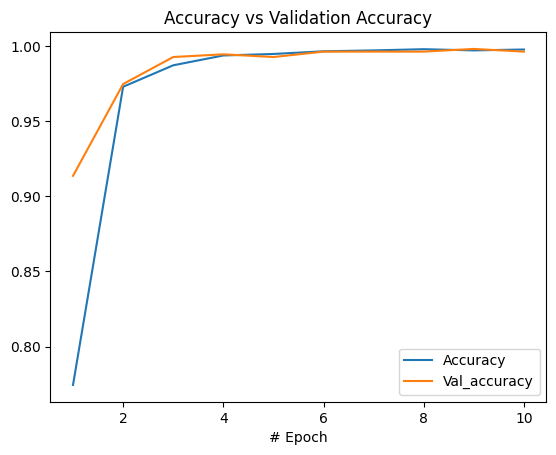

In [ ]:
acc = []
val_acc = []
for i in range(len(history.history["accuracy"])):
    acc.append( history.history["accuracy"][i])
    val_acc.append( history.history["val_accuracy"][i])
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()

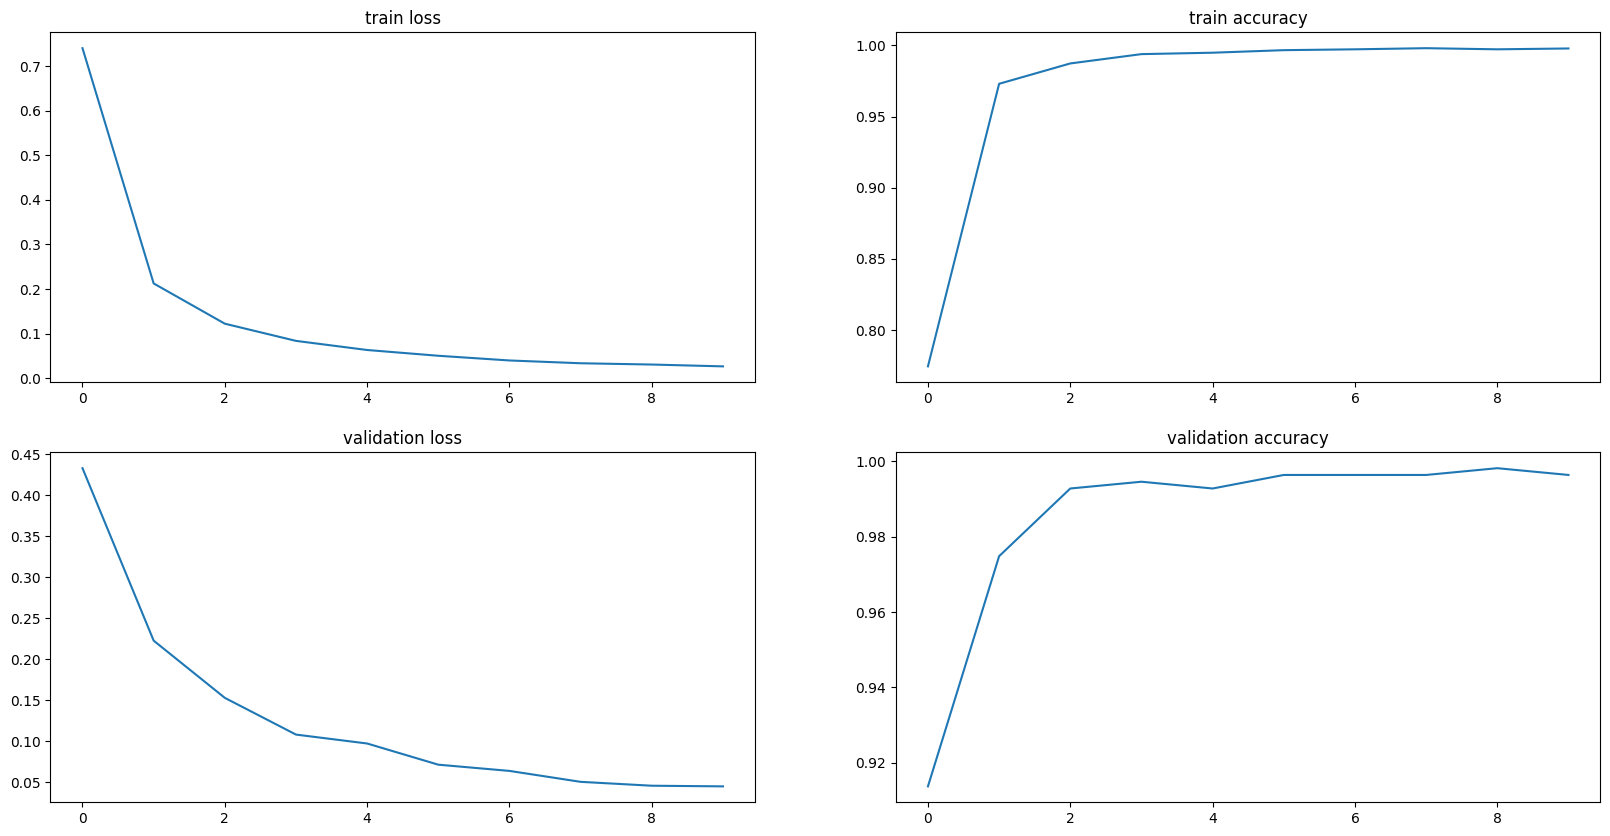

In [ ]:
plot_history(history)

In [15]:
def get_y_pred(model, test_generator):  
    
    predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
    return np.argmax(predictions, axis=1)

In [16]:
y_pred= get_y_pred(model, test_generator)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=categories))


<ipython-input-15-5274a92c82da>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)


10/10 [==============================] - 108s 12s/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        61
           B       1.00      1.00      1.00        79
           C       1.00      1.00      1.00        68
           D       0.99      0.99      0.99        73
           E       1.00      1.00      1.00        55
           F       1.00      1.00      1.00       210

    accuracy                           1.00       546
   macro avg       1.00      1.00      1.00       546
weighted avg       1.00      1.00      1.00       546



Text(50.722222222222214, 0.5, 'True labels')

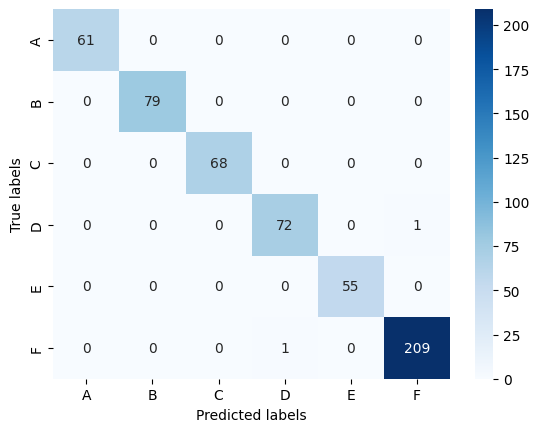

In [18]:
cm = confusion_matrix(y_true, y_pred)

ax = heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=categories, yticklabels=categories)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')

In [ ]:
#model.save("models/apple_classifier.h5")



C:\Users\arkad\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
#model.save('models/my_model.keras')
model.save('/content/drive/MyDrive/4 Deep Learning - Types of apples/data/my_model.keras')


In [19]:
#model.save('models/netv2_model.keras')
model.save('/content/drive/MyDrive/4 Deep Learning - Types of apples/data/net2_model.keras')